
**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, ConcatDataset
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm.notebook import tqdm

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
#1e-2
#1e-3
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

ALPHA = 0.1

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# ATTENZION
#ATTTENZIONE
# NORMALIZZARE CON VALORI DEL DATASE IMAGENET SE NET è PRETRAINATA
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.RandomCrop( 64 , padding =2) ,
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                    
])

**Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework3_PACS'):
  !git clone https://github.com/RoboTuan/Homework3_PACS.git

DATA_DIR = 'Homework3_PACS'

DATA_DIR_train = 'Homework3_PACS/PACS/photo'
DATA_DIR_test = 'Homework3_PACS/PACS/art_painting'

# Prepare Pytorch train/test Datasets
train_dataset = torchvision.datasets.ImageFolder(DATA_DIR_train, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(DATA_DIR_test, transform=eval_transform)

#train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
#test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]

#train_dataset = Subset(train_dataset, train_indexes)
#test_dataset = Subset(test_dataset, test_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 1670
Test Dataset: 2048


In [0]:
train_distr = np.zeros(7)
for index in range(len(train_dataset)):
  label = train_dataset.__getitem__(index)[1]
  train_distr[label] += 1

test_distr = np.zeros(7)
for index in range(len(test_dataset)):
  label = test_dataset.__getitem__(index)[1]
  test_distr[label] += 1
  

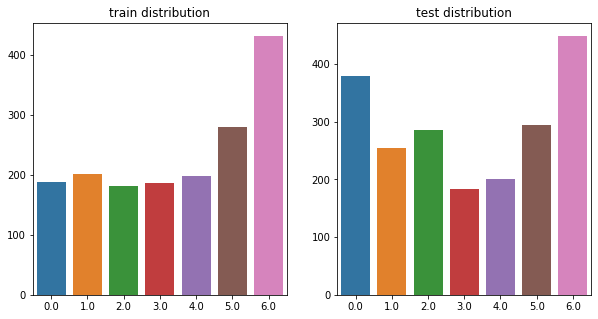

In [0]:
figure, axes = plt.subplots(1, 2, figsize=(10,5))
sns.barplot(x=np.linspace(0, 6, 7), y=train_distr, ax=axes[0]).set_title("train distribution")
sns.barplot(x=np.linspace(0, 6, 7), y=test_distr, ax=axes[1]).set_title("test distribution")
plt.show()

**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

In [0]:
from Homework3_PACS.gradient_reversal_example import alexnetDANN

**Prepare Network**

In [0]:
kwargs = {'num_classes':7, 'num_domain_classes':2}
net = alexnetDANN(pretrained=True, **kwargs) # Loading AlexNet model

In [0]:
#net = alexnet(pretrained = True)
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

**Train on Photo, and Test on Art painting without adaptation**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [0]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 2.5209784507751465
Starting epoch 2/30, LR = [0.01]
Step 10, Loss 1.133375883102417
Starting epoch 3/30, LR = [0.01]
Starting epoch 4/30, LR = [0.01]
Step 20, Loss 1.041648507118225
Starting epoch 5/30, LR = [0.01]
Starting epoch 6/30, LR = [0.01]
Step 30, Loss 0.9261630773544312
Starting epoch 7/30, LR = [0.01]
Step 40, Loss 0.864020824432373
Starting epoch 8/30, LR = [0.01]
Starting epoch 9/30, LR = [0.01]
Step 50, Loss 0.7822348475456238
Starting epoch 10/30, LR = [0.01]
Starting epoch 11/30, LR = [0.01]
Step 60, Loss 0.8616864681243896
Starting epoch 12/30, LR = [0.01]
Step 70, Loss 0.7865439057350159
Starting epoch 13/30, LR = [0.01]
Starting epoch 14/30, LR = [0.01]
Step 80, Loss 0.8040544986724854
Starting epoch 15/30, LR = [0.01]
Starting epoch 16/30, LR = [0.01]
Step 90, Loss 0.7862322330474854
Starting epoch 17/30, LR = [0.01]
Step 100, Loss 0.713293731212616
Starting epoch 18/30, LR = [0.01]
Starting epoch 19/30, LR = [0.01]
Step

**Test**

In [0]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))


Test Accuracy: 0.40966796875


**Domain adaptation**


In [0]:
#joint_dataset = ConcatDataset([train_dataset, test_dataset])
#len(joint_dataset)

In [0]:
kwargs = {'num_classes':7, 'num_domain_classes':2}
net = alexnetDANN(pretrained=True, **kwargs) # Loading AlexNet model

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
class Train_Test:
  def __init__(self, network, source, target):

    self.source_dataloader = source
    self.target_dataloader = target

    self.network = network.to(DEVICE)

    cudnn.benchmark # Calling this optimizes runtime

    self.max_batches = min(len(self.source_dataloader), len(self.target_dataloader))


  def train(self):
    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      print("**********************************")
      print("Starting epoch {}/{} LR = {}".format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
      
      dl_source_iter = iter(train_dataloader)
      dl_target_iter = iter(test_dataloader)

      for batch in range(self.max_batches):
        optimizer.zero_grad()

        # Train on source
        images_s, labels_s = next(dl_source_iter)
        images_s = images_s.to(DEVICE)
        labels_s = labels_s.to(DEVICE)

        class_pred = net(images_s)
        loss_s_label = criterion(class_pred, labels_s)
        #loss_s_label.backward()

        # Train on source domain
        labels_s_domain = torch.zeros(BATCH_SIZE, dtype=torch.long) # generate source domain labels
        labels_s_domain = labels_s_domain.to(DEVICE)

        domain_pred = net(images_s, ALPHA)
        loss_s_domain = criterion(domain_pred, labels_s_domain)
        #loss_s_domain.backward()

        # Train on target domain
        images_t, _ = next(dl_target_iter) # ignore target domain class labels!
        labels_t_domain = torch.ones(BATCH_SIZE, dtype=torch.long) # generate target domain labels
        images_t = images_t.to(DEVICE)
        labels_t_domain = labels_t_domain.to(DEVICE)

        domain_pred = net(images_t, ALPHA)
        loss_t_domain = criterion(domain_pred, labels_t_domain)
        #loss_t_domain.backward()

        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step() # update weights based on accumulated gradients

        print(f"class_loss: {loss_s_label.item():.4f} s_domain_loss: {loss_s_domain.item():.4f} t_domain_loss: {loss_t_domain.item():.4f}")        
      
      # Step the scheduler
      scheduler.step() 

  def test(self):
    #self.network = self.network.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    self.network.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(self.target_dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = self.network(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))

    print('Test Accuracy: {}'.format(accuracy))

In [0]:
train_test = Train_Test(net, train_dataloader, test_dataloader)
train_test.train()

**********************************
Starting epoch 1/30 LR = [0.01]
class_loss: 2.9201 s_domain_loss: 0.9964 t_domain_loss: 0.7434
**********************************
Starting epoch 2/30 LR = [0.01]
class_loss: 3.6641 s_domain_loss: 0.0165 t_domain_loss: 1.1746
**********************************
Starting epoch 3/30 LR = [0.01]
class_loss: 2.7321 s_domain_loss: 0.9411 t_domain_loss: 0.1117
**********************************
Starting epoch 4/30 LR = [0.01]
class_loss: 1.5389 s_domain_loss: 0.2091 t_domain_loss: 0.3078
**********************************
Starting epoch 5/30 LR = [0.01]
class_loss: 1.3378 s_domain_loss: 0.1020 t_domain_loss: 0.4524
**********************************
Starting epoch 6/30 LR = [0.01]
class_loss: 1.2210 s_domain_loss: 0.2067 t_domain_loss: 0.2980
**********************************
Starting epoch 7/30 LR = [0.01]
class_loss: 1.2504 s_domain_loss: 0.2357 t_domain_loss: 0.3987
**********************************
Starting epoch 8/30 LR = [0.01]
class_loss: 1.2913 s_do

In [0]:
train_test.test()


Test Accuracy: 0.16341463414634147
